# ReAct Agent
Notebook for exploration of a basic ReAct agent.

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv, dotenv_values

In [2]:
load_dotenv(Path.cwd().parent / '.env')

True

## Basic ChatBot structure
* `StateGraph` will define the chatbot structure as 'state machine'
* `nodes` will be the functions calling
* `edges` how the chatbot will transition between functions

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

In [4]:
class State(TypedDict):
    """
    messages are a list, and add_messages is a function that adds a message to the list instead of
    overwrite them.
    """
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [5]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

def chatbot(state: State):
    return {"messages": [chatgpt.invoke(state["messages"])]}

# now start defining nodes to the graph
graph_builder.add_node("chatbot", chatbot)

In [6]:
# after defining the first node, need to define the initial state
# it means where to start svery time the graph is called
graph_builder.set_entry_point("chatbot")

# and define the end state as well
# in this way the ghaph will stop when the end state is reached
graph_builder.set_finish_point("chatbot")

# last step is to compile the graph
graph = graph_builder.compile()

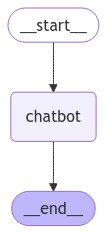

In [7]:
from IPython.display import display, Image, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# test the graph
prompt = "What's the largest mammal in the world?"
response = graph.invoke({"messages": ("user", prompt)})

In [10]:
response

{'messages': [HumanMessage(content="What's the largest mammal in the world?", id='ab7f7424-e19f-47d4-9733-1e9cef513e53'),
  AIMessage(content='The largest mammal in the world is the blue whale (*Balaenoptera musculus*). Blue whales can reach lengths of up to 100 feet (30 meters) and can weigh as much as 200 tons or more. They are known for their immense size and are found in oceans around the globe.', response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 16, 'total_tokens': 81, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-8a02fe38-c06e-4d52-bf3c-9d33c56b2e11-0')]}

In [11]:
# display in markdown
display(Markdown(response["messages"][-1].content))

The largest mammal in the world is the blue whale (*Balaenoptera musculus*). Blue whales can reach lengths of up to 100 feet (30 meters) and can weigh as much as 200 tons or more. They are known for their immense size and are found in oceans around the globe.

## Add Tools to the graph.